## Introduction

Imagine that you work for a company that develops mobile games. A manager came to you with a number of tasks to study several aspects of a mobile application:

1. First of all, the manager is interested in the retention indicator. Write a function to calculate it.
2. In addition, the company conducted A / B testing of sets of promotional offers. Based on the available data, determine which set can be considered the best and on the basis of which metrics it is worth making the right decision.
3. Offer metrics to evaluate the results of the last past thematic event in the game.

### Task 1. Retention

Retention is one of the most important indicators in a company.
The task is to write a function that will count the retention of players (by days from the date of registration of a player).
The function must be written in python.
During the solution, the operation of the function can be tested on both the full dataset and on a sample of data.

In [1]:
# importing libraries

import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

To solve the problem, two csv files are being used:
- problem1-reg_data.csv - registration time data
- problem1-auth_data.csv - data about the time when users logged in the game

Uploading data and conducting basic EDA:

In [2]:
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-stepanyan/shared/problem1-reg_data.csv',
                       sep = ';')
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [3]:
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-stepanyan/shared/problem1-auth_data.csv',
                        sep = ';')
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [4]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [5]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Converting  unix timestamp format into datetime and finding the last registration date:

In [6]:
reg_data['reg_ts'] = reg_data['reg_ts'].apply(dt.fromtimestamp)
reg_data.head()

,reg_ts,uid
0,1998-11-18 12:43:43,1
1,1999-07-23 02:38:09,2
2,2000-01-14 01:27:27,3
3,2000-05-28 18:19:01,4
4,2000-09-16 15:21:53,5


In [7]:
max_reg_date = reg_data.reg_ts.max()
print(max_reg_date)

2020-09-23 18:17:24


In [8]:
auth_data['auth_ts'] = auth_data['auth_ts'].apply(dt.fromtimestamp)
auth_data.head()

,auth_ts,uid
0,1998-11-18 12:43:43,1
1,1999-07-23 02:38:09,2
2,1999-07-25 20:46:46,2
3,1999-07-31 07:50:15,2
4,1999-08-05 21:49:39,2


In [9]:
# Finding missing values

reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [10]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [11]:
# Finding duplicates

reg_data.duplicated().value_counts()

False    1000000
dtype: int64

In [12]:
auth_data.duplicated().value_counts()

False    9601013
dtype: int64

Data seems clean, no missing values or dublicates. Merging tables:

In [13]:
merged_data = pd.merge(reg_data, auth_data, on = 'uid')
merged_data.head()

,reg_ts,uid,auth_ts
0,1998-11-18 12:43:43,1,1998-11-18 12:43:43
1,1999-07-23 02:38:09,2,1999-07-23 02:38:09
2,1999-07-23 02:38:09,2,1999-07-25 20:46:46
3,1999-07-23 02:38:09,2,1999-07-31 07:50:15
4,1999-07-23 02:38:09,2,1999-08-05 21:49:39


In [14]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column   Dtype         
---  ------   -----         
 0   reg_ts   datetime64[ns]
 1   uid      int64         
 2   auth_ts  datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 293.0 MB


Setting a function for calculating the retention rate by day (which is the most relevant for gamedev), the result of which will be a cohort table. The function parameters are as follows:

- __reg_path__ - the first path to a file

- __auth_path__ - second path to a file

- __start_date__ - start date of retention calculation

- __end_date__ - end date of retention calculation

In [15]:
def get_retention_rate_table(reg_path, auth_path, start_date, end_date):
    
    """The data is uploaded, converted to the required data type, filtered by date.
    Then the tables are merged, cohorts are formed, the pivot table is calculated 
    and the retention rate is calculated in%.
    The function call produces a visualization of the final table.
    """
    
    reg_data = pd.read_csv(reg_path, sep = ';')
    auth_data = pd.read_csv(auth_path, sep = ';')
    
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')\
                           .dt.date.astype('datetime64')
    
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')\
                             .dt.date.astype('datetime64')
    
    reg_data = reg_data.query('reg_ts >= @start_date & reg_ts <= @end_date')
    auth_data = auth_data.query('auth_ts >= @start_date & auth_ts <= @end_date')
    
    df = reg_data.merge(auth_data, on = 'uid')

    df['cohort_day'] = (df['auth_ts'] - df['reg_ts']).dt.days
    df = df.rename(columns = {'reg_ts': 'cohort_date'})
    df['cohort_date'] = df['cohort_date'].dt.to_period('D')
    
    pivot = df.pivot_table(columns = 'cohort_day', index = 'cohort_date',
                           values = 'uid', aggfunc = 'nunique')
    
    cohort_table_percentage = pivot.divide(pivot.iloc[:,0], axis=0).mul(100).round(2)

    # visualization
    
    plt.figure(figsize = (22,17))
    x = sns.heatmap(
        cohort_table_percentage, vmin = 0, 
        vmax = 10, annot = True, 
        annot_kws = {'fontsize':'x-large'},
        fmt = '.2f', linewidth=.1, cmap = 'Blues')

    # The table name and labels

    plt.title('Retention Rate by day, %', size = 22)
    plt.xlabel('retention_day', size = 20)
    plt.ylabel('registration_date', size = 20)
    x.set_yticklabels(x.get_yticklabels(), rotation = 0)
    plt.show()

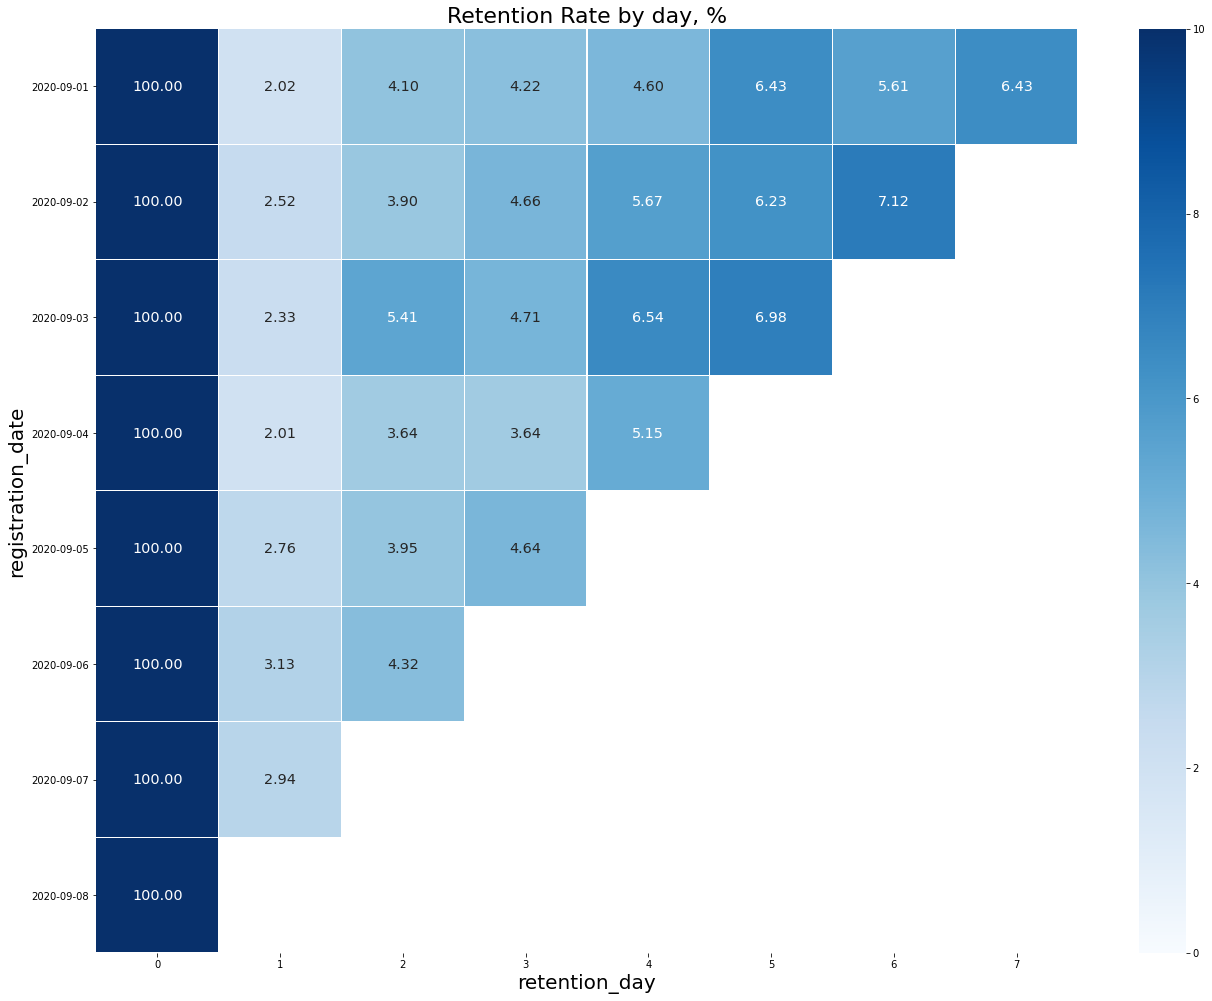

In [16]:
reg_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-stepanyan/shared/problem1-reg_data.csv'
auth_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-stepanyan/shared/problem1-auth_data.csv'
start_date = "2020-09-01"
end_date = "2020-09-08"

get_retention_rate_table(reg_path, auth_path, start_date, end_date)

### Task 2. A/B test

There are results of an A / B test in which two groups of users were offered different sets of promotional offers.

It is known that ARPU in the test group is 5% higher than in the control group.
At the same time, in the control group, 1928 players out of 202103 turned out to be paying, and in the test group - 1805 out of 202667.

What set of recommendations can be considered the best? What metrics should be analyzed to make the right decision and how?

In [17]:
# importing libraries

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import chi2_contingency, chi2

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

Uploading data and conducting EDA:

In [18]:
ab_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-stepanyan/my_finals/project_1_task_2.csv',
                      sep = ';')
ab_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [19]:
ab_df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [20]:
ab_df.describe() 

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [21]:
ab_df.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

In [22]:
double_variant_count = ab_df.groupby('user_id')['testgroup'].nunique().value_counts()
double_variant_count

1    404770
Name: testgroup, dtype: int64

In [23]:
ab_df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [24]:
ab_df.duplicated().value_counts()

False    404770
dtype: int64

The data is ready for analysis, there are no double variants for users, duplicates and missing values.
It is also known from the condition that only a small share of users is paying, so in the future two types of distributions will be possibly considered - including and excluding non-paying users.

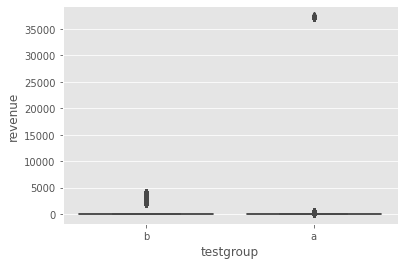

In [25]:
# First, let's look at the outliers in groups

sns.boxplot(x='testgroup', y='revenue', data = ab_df)

Quite an interesting situation, but remembering the small share of paying users in both groups: in the control ~ 0.95%, in the test ~ 0.89%, it turns out that all values other than zero will be a kind of outlier.
But let's not stop here. Let's look at the shape of the distributions:

In [26]:
a = ab_df.query('testgroup == "a"')
b = ab_df.query('testgroup == "b"')

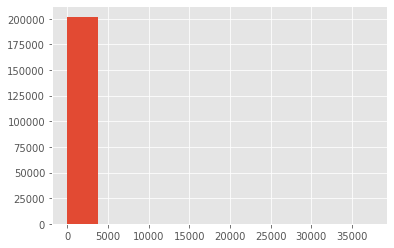

In [27]:
a.revenue.hist()

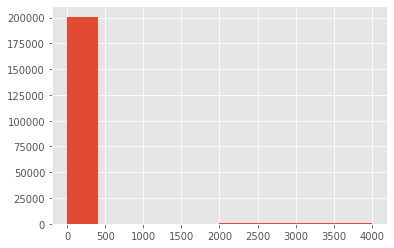

In [28]:
b.revenue.hist()

Both distributions are strongly shifted to the left, but it is clear that it's because of the overwhelming number of non-paying users. To make sure, the Shapiro-Wilk test is conducted.
- H0 = distribution is normal
- H1 = distribution is abnormal

In [29]:
shapiro(a.revenue)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

In [30]:
shapiro(b.revenue)

ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)

The Shapiro-Wilk test is quite powerful, but works best for small to medium sized samples, and even python warns,
that the test may be inaccurate. Just in case, let's run through the Anderson-Darling test, which works well for medium and large sample sizes. For this test also H0 = the distribution is normal, but the test results are interpreted as follows: if the test statistics are higher than the critical values, then we can assume that the distribution is not normal:

In [31]:
anderson(a.revenue) # distribution is abnormal

AndersonResult(statistic=77221.00043053087, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [32]:
anderson(b.revenue) # distribution is abnormal

AndersonResult(statistic=77383.39298710425, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Now let's leave only the paying users, and look at the distributions in this case:

In [33]:
a_pay = ab_df.query('testgroup == "a" & revenue !=0')

In [34]:
b_pay = ab_df.query('testgroup == "b" & revenue !=0')

In [35]:
a_pay.head()

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
416,417,37324,a
712,713,255,a


In [36]:
b_pay.head()

,user_id,revenue,testgroup
160,161,3797,b
377,378,3768,b
386,387,3527,b
551,552,2038,b
913,914,3902,b


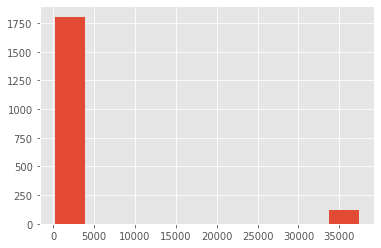

In [37]:
a_pay.revenue.hist()

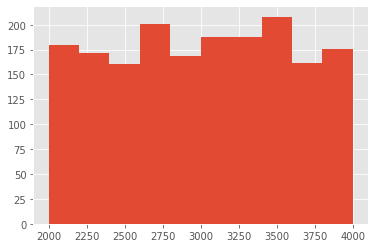

In [38]:
b_pay.revenue.hist()

In [39]:
shapiro(a_pay.revenue)

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [40]:
shapiro(b_pay.revenue)

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

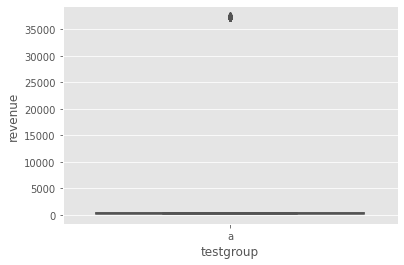

In [41]:
sns.boxplot(x='testgroup', y='revenue', data = a_pay)

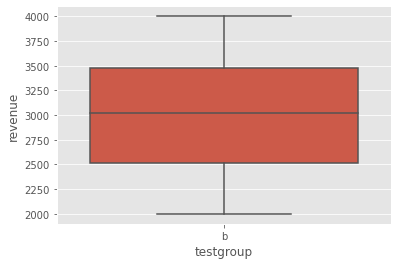

In [42]:
sns.boxplot(x='testgroup', y='revenue', data = b_pay)

For paying users, the distributions are already different, for group A the distribution is still abnormal and has a strong outlier, for group B everything has returned to normality. Let's take a closer look at the outlier in group A:

In [43]:
big_spenders = a_pay.query('revenue > 5000')

In [44]:
big_spenders.describe()

,user_id,revenue
count,123.000000,123.000000
mean,203513.073171,37319.121951
std,116745.137742,25.442183
min,417.000000,37293.000000
25%,109013.500000,37301.000000
50%,204560.000000,37311.000000
75%,317108.500000,37329.000000
max,399295.000000,37433.000000


Let's find out what part of the income in the control group has been brought by the players who's spent a lot in the game, and how much has been brought by all the rest:

In [45]:
big_spenders_rev = big_spenders.revenue.sum()

In [46]:
low_spenders_rev = a_pay.query('revenue < 37293').revenue.sum()

In [47]:
big_spenders_rev_perc = round((big_spenders_rev/(big_spenders_rev + low_spenders_rev))*100, 2)

In [48]:
big_spenders_rev_perc

89.37

In [49]:
low_spenders_rev_perc = round((low_spenders_rev/(big_spenders_rev + low_spenders_rev))*100, 2)

In [50]:
low_spenders_rev_perc

10.63

That is, a significant part of the income (89.4%) for group A has been brought by a group of users of 123 people who were ready to spend a lot for a specific promotional offer. Definitely worth looking at this group in the future, exploring what attracted them and what common characteristics they have in order to form such a promotional offer for the audience that can bring the highest income. 
But in general, the situation with this particular case is rather unstable and may be an elementary error in the data,  for a long-term planning a more uniform distribution and predictable outcome is desirable.

Now let's continue comparing the two groups to see if there are any statistical differences between them. The metrics that should be taken into consideration are ARPU, ARPPU and conversion, let's calculate it:

In [51]:
arpu_a = a.revenue.mean().round(2)
arpu_a

25.41

In [52]:
arpu_b = b.revenue.mean().round(2)
arpu_b

26.75

In [53]:
arppu_a = a_pay.revenue.mean().round(2)
arppu_a

2664.0

In [54]:
arppu_b = b_pay.revenue.mean().round(2)
arppu_b

3003.66

In [55]:
conversion_a = round((a_pay.user_id.nunique()/a.user_id.nunique())*100, 2)
conversion_a

0.95

In [56]:
conversion_b = round((b_pay.user_id.nunique()/b.user_id.nunique())*100, 2)
conversion_b

0.89

For ARPU and ARPPU stat tests, the non-parametric __bootstrap__ method will be used:

In [57]:
def get_bootstrap(
    data_column_1, # numeric values of the first sample
    data_column_2, # numeric values of the second sample
    boot_it = 1000, # number of bootstrap subsamples
    statistic = np.mean, # the statistics we are interested in
    bootstrap_conf_level = 0.95 # significance level
):
    boot_data = []
    for i in tqdm(range(boot_it)): # extracting subsamples
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - applying statistics
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Visualization
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

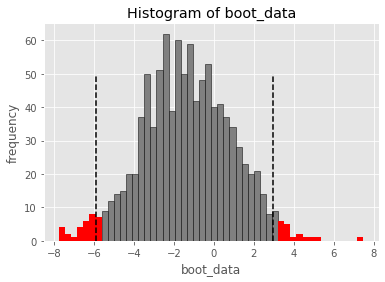

In [58]:
booted_arpu = get_bootstrap(a.revenue, b.revenue)

In [59]:
booted_arpu['p_value']

0.5453793454689134

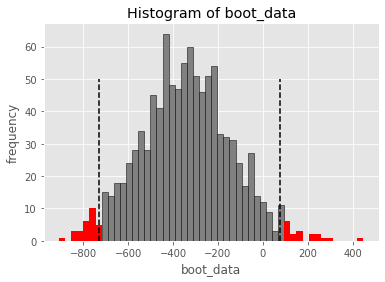

In [60]:
booted_arppu = get_bootstrap(a_pay.revenue, b_pay.revenue)

In [61]:
booted_arppu['p_value'] 

0.09089996881964553

It remains to conduct a test for the difference in conversions and draw conclusions. For comparing conversions, Pearson's chi-square is a good method, but first a column with categorical variables is created:

In [62]:
conversion_testing = ab_df

In [63]:
conversion_testing['paid'] = conversion_testing.revenue.apply(lambda x: 'paid' if x > 0 else 'not_paid')

In [64]:
conversion_testing.head()

,user_id,revenue,testgroup,paid
0,1,0,b,not_paid
1,2,0,a,not_paid
2,3,0,a,not_paid
3,4,0,b,not_paid
4,5,0,b,not_paid


In [65]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(conversion_testing.paid, conversion_testing.testgroup))

In [66]:
p 

0.03647561892312613

The chi-square test showed a statistically significant difference for conversions.

### Conclusion

The bootstrap statistical test method separately for ARPU and ARPPU, as well as Pearson's chi-square method to compare conversions have been used for the analysis:

- Despite the fact that ARPU in group B is higher by 5% than in group A, the test did not show a statistically significant difference between the groups.

- For paying users, bootstrap also did not show a statistically significant difference between A and B. However, it was observed that in group A, user behavior is very erratic, 123 users have brought almost 90% of the income in this group.

- Pearson's test for the difference in purchase conversions showed a statistically significant difference between the groups, the conversion was 0.95% for group A, 0.89% for group B.

### Recommendations

If to choose which of the 2 sets of promotional offers to implement to a larger audience, I would recommend the group B's option:

- The distribution of paying users is more even, predictable, and ARPU and ARPPU are on average higher than in group A. Here you can sacrifice a conversion a little bit for the sake of security.

- It would be great to take a closer look at the abnormally high spending user group in group A (if this is not a data error). What that is users liked so much about this particular promotion. If these characteristics are identified, 
one more more targeted test can be conducted with an equal number of users in the samples, and if the test shows a statistical significance individual (?) promotions could be provided to such users in the future.

### Task 3

Plants & Gardens has a limited-time themed event every month where players can get unique items for the garden and characters, additional coins or bonuses. To receive a reward, users need to complete a series of levels in a certain time. What metrics can be used to evaluate the results of the last past event?

Supposably, in another event, we have complicated the mechanics of events so that for each unsuccessful attempt to complete the level, a player will roll back several levels. Will the set of performance evaluation metrics change? If so, how?



### Solution:

Examples of metrics that can be used to evaluate the results of the last past event:

1. __1-7, 30 day retention rate__ -  percentage of players who continue to log into the game after participating in the event can be calculated.


2. __DAU/WAU/MAU__ (depending on the duration of an event) - the metric of the audience active for a period.


3. __Stickiness rate (DAU/MAU)__ - will show how "sticky" the game is, a result of 20% and above is considered as very good.

4. __Conversion Rate, Revenue, ARPU, ARPPU__ - if there is a possibility to make a purchase or some other target actions in this event, then it can be measured.


5. __Time spent__ - the average time spent in the game during the event compared to the regular game. If players spend more time, then the level of engagement has become higher.


6. __Session length__ - user session time.


7. __ASL__ -  average session time of users.


7. __Frequency of game sessions during the event__ - number of sessions for n period during the event or during the event in total.

9. __Time-to-Complete Event__ - the average time it takes players to complete the event. This metric can indicate how well the duration and difficulty of levels of the event are balanced and how interesting it is for players.


10. __Achievements and progress__ - number of levels completed, rewards received during the event.

11. __In-app ad performance (if there are ads):__  number of impressions, CTR, CR. These metrics help to evaluate the effectiveness of the event's promotional elements.


12. __Player Feedback__ - surveys, reviews, or in-app feedback mechanisms. Qualitative data on players satisfaction, their perception of the value of the event, and suggestions for improvement.


13. __Contact Support__ - the number of hits and complaints can be tracked, the increase of which can be an indicator of problems in the game / event.


In case of complicating the mechanics of the event, in which the player rolls back several levels, it will be useful to add a couple more metrics:

14. __Churn rate__ - counts the percentage of players who have stopped interacting with a game after participating in the event.


15. __Funnel Conversion__ - it is possible to track at which levels players fail the most in order to identify bottlenecks, the stages at which players stop playing. These levels can be eased or could be developed in a more interesting way in the future.